# Libraries

In [1]:
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
import os

## Load data and resample

In [2]:
# load the dataset
def load_dataset(file_path):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # correct data types
    fix_cols = data_df.columns[data_df.dtypes == 'object']
    data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')
    # remove redundant features
    data_df.drop(['total_review_count', 'halal_review_count', 'halal_negation_count'], inplace=True, axis=1)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# define resampling method
def split_and_resample(X, y, test_size=0, resampling=None):
    if test_size > 0:
        # setting up testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        x_train, x_test, y_train, y_test = X, pd.DataFrame(columns=X.columns, dtype=X.dtypes.values),\
                                            y, pd.Series(name=y.name, dtype=y.dtypes)
    # concatenate our training data back together
    X = pd.concat([x_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    if not resampling:
        return x_train, y_train, x_test, y_test
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, x_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, x_test, y_test
    elif resampling == 'SMOTE':
        x_train, y_train = SMOTE().fit_sample(x_train, y_train)
        return x_train, y_train, x_test, y_test

# define models to test
def get_models():
    models = list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    # CART
    models.append(DecisionTreeClassifier()) # max depth set to 15 to avoid overfitting
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    # RF
    models.append(RandomForestClassifier(n_estimators=10))
    # XGBoost
    models.append(XGBClassifier(learning_rate = 0.05, n_estimators=300))
    return models

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, error_score='raise')
    return scores

>DummyClassifier 0.865 (0.001)
>DecisionTreeClassifier 0.889 (0.021)
>Pipeline 0.908 (0.025)
>RandomForestClassifier 0.909 (0.023)
>XGBClassifier 0.931 (0.027)


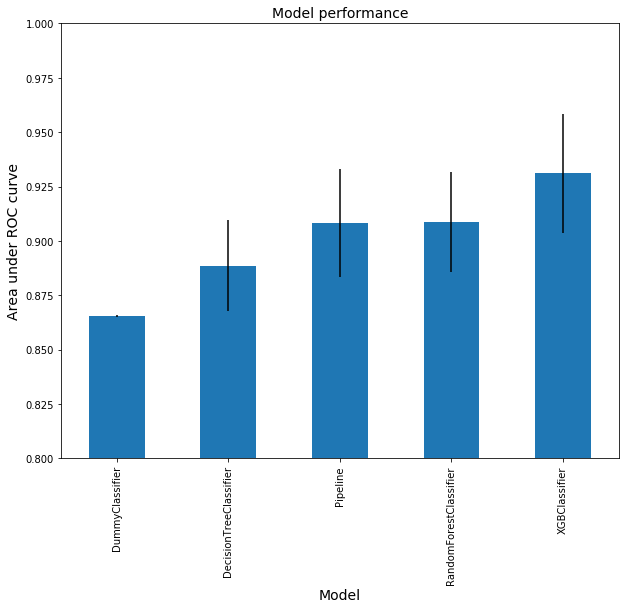

In [3]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define models
models = get_models()
# evaluate each model
results = list()
for i, model in enumerate(models):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, model)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))

# plot the results
plot_df = pd.DataFrame(columns=['models', 'results'])
plot_df['models'] = [model.__class__.__name__ for model in models]
plot_df['results'] = [result.tolist() for result in results]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)
ax = plot_df.plot(kind='bar', y='mean', x='models', yerr='sd', legend=False, figsize=(10,8))
ax.set_ylim(0.8,1)
ax.set_title('Model performance', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylabel('Area under ROC curve', size=14)
plt.show()

## Compare different resampling methods

In [4]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# define models and resampling methods
models = get_models()
resampling = [None, 'oversample', 'undersample', 'SMOTE']
# evaluate each model
results = list()
for resample_method in resampling:
    # split and oversample
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling=resample_method)
    print('>>%s: ' % str(resample_method).upper())
    for model in models:
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, scores.mean(), scores.std()))
        # evaluate against test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(' >accuracy: %.3f'  % accuracy_score(y_test, y_pred))
        print(' >recall: %.3f' % recall_score(y_test, y_pred))
    print()

>>NONE: 
>DummyClassifier 0.865 (0.001)
 >accuracy: 0.732
 >recall: 1.000
>DecisionTreeClassifier 0.894 (0.019)
 >accuracy: 0.726
 >recall: 0.813
>Pipeline 0.907 (0.024)
 >accuracy: 0.756
 >recall: 0.902
>RandomForestClassifier 0.907 (0.023)
 >accuracy: 0.726
 >recall: 0.829
>XGBClassifier 0.930 (0.021)
 >accuracy: 0.750
 >recall: 0.894

>>OVERSAMPLE: 
>DummyClassifier 0.750 (0.001)
 >accuracy: 0.732
 >recall: 1.000
>DecisionTreeClassifier 0.921 (0.022)
 >accuracy: 0.702
 >recall: 0.797
>Pipeline 0.880 (0.031)
 >accuracy: 0.738
 >recall: 0.748
>RandomForestClassifier 0.931 (0.025)
 >accuracy: 0.744
 >recall: 0.805
>XGBClassifier 0.937 (0.021)
 >accuracy: 0.744
 >recall: 0.780

>>UNDERSAMPLE: 
>DummyClassifier 0.750 (0.005)
 >accuracy: 0.774
 >recall: 1.000
>DecisionTreeClassifier 0.797 (0.053)
 >accuracy: 0.637
 >recall: 0.592
>Pipeline 0.803 (0.061)
 >accuracy: 0.667
 >recall: 0.631
>RandomForestClassifier 0.807 (0.074)
 >accuracy: 0.673
 >recall: 0.600
>XGBClassifier 0.820 (0.062)
 >

## Feature importance from Random Forest w/ oversampling

In [10]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset
X, y = load_dataset(file_path)
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')

# initialize RF with different depths
depths = range(1, X.shape[1])
cv = 5
plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
depths_list = [[depth]*cv for depth in depths]
plot_df['depth'] = [item for items in depths_list for item in items]
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

for i in range(0, plot_df.shape[0],5): 
    model = RandomForestClassifier(max_depth=plot_df.loc[i, 'depth'])
    # train model and collect metrics
    cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = cv, n_jobs = -1)
    plot_df.loc[i:i+cv-1, 'accuracy'] = cv_scores['test_acc']
    plot_df.loc[i:i+cv-1, 'precision'] = cv_scores['test_prec']
    plot_df.loc[i:i+cv-1, 'recall'] = cv_scores['test_rec']
    plot_df.loc[i:i+cv-1, 'f1'] = cv_scores['test_f1']

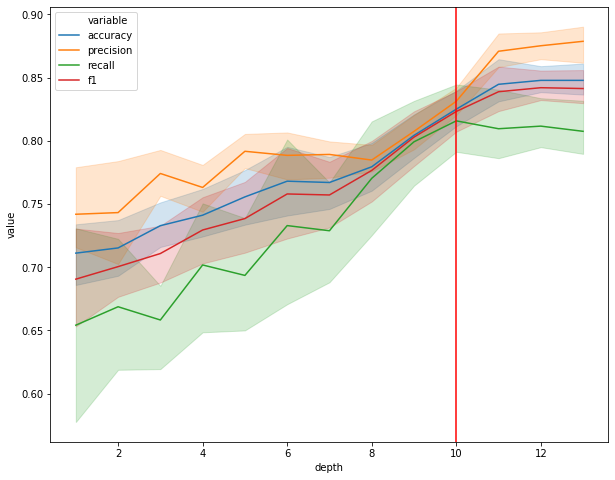

In [14]:
# visualize decision tree metrics vs max_depth
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=10, color='red')
plt.show()

Accuracy:  0.768
Precision: 0.858
Recall:    0.824
f1:        0.841
Confusion matrix: 
 [[ 26  17]
 [ 22 103]]
Classification report: 
               precision    recall  f1-score   support

       False       0.54      0.60      0.57        43
        True       0.86      0.82      0.84       125

    accuracy                           0.77       168
   macro avg       0.70      0.71      0.71       168
weighted avg       0.78      0.77      0.77       168



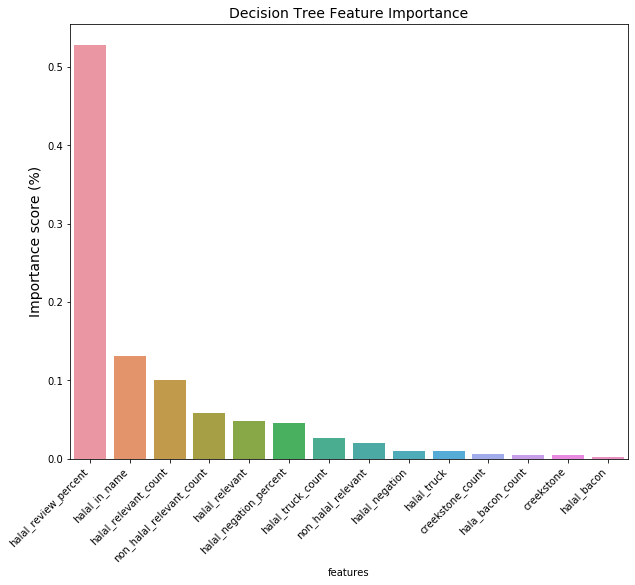

In [6]:
# use max depth of 13
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

# model performance on test set
y_pred = model.predict(X_test)
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

# Feature importance from RF
plot_df = pd.DataFrame(data={'importances': model.feature_importances_, 'features': X.columns})

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=plot_df['features'], y=plot_df['importances'],
                order=plot_df.sort_values('importances', ascending=False).features)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Decision Tree Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
plt.show()

## Trying RF with class_weight

In [7]:
# split and oversample
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:25, 1:75}]
param_grid = dict(class_weight=balance)

# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.704694 using {'class_weight': {0: 1, 1: 100}}
0.664401 (0.049978) with: {'class_weight': {0: 100, 1: 1}}
0.671330 (0.050122) with: {'class_weight': {0: 10, 1: 1}}
0.684092 (0.059657) with: {'class_weight': {0: 1, 1: 1}}
0.700199 (0.060549) with: {'class_weight': {0: 1, 1: 10}}
0.704694 (0.058614) with: {'class_weight': {0: 1, 1: 100}}
0.699593 (0.052557) with: {'class_weight': {0: 25, 1: 75}}


### There is not significant difference between different weights.

## Feature importance from XGBoost

In [8]:
## tuning xgboost
# split data
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2)

## training and tuning model
params = {
    # Parameters to tune
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 0.8,
    'colsample_bytree': 1,
}
model = XGBClassifier(max_depth=12,
                        subsample=0.8,
                        n_estimators=300,
                        learning_rate = 0.01)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15,
          eval_metric=['aucpr', "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-aucpr:0.94351	validation_0-logloss:0.68808	validation_1-aucpr:0.94072	validation_1-logloss:0.68849
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-aucpr:0.95295	validation_0-logloss:0.68306	validation_1-aucpr:0.94581	validation_1-logloss:0.68362
[2]	validation_0-aucpr:0.95386	validation_0-logloss:0.67832	validation_1-aucpr:0.94412	validation_1-logloss:0.67924
[3]	validation_0-aucpr:0.95440	validation_0-logloss:0.67353	validation_1-aucpr:0.94360	validation_1-logloss:0.67480
[4]	validation_0-aucpr:0.95493	validation_0-logloss:0.66870	validation_1-aucpr:0.94422	validation_1-logloss:0.67024
[5]	validation_0-aucpr:0.95499	validation_0-logloss:0.66419	validation_1-aucpr:0.94198	validation_1-logloss:0.66652
[6]	validation_0-aucpr:0.96140	validation_0-logloss:0.65964	validation_1-aucpr:0.94631	validation_1-logloss:0.66248
[7]	validation_0-aucpr:

[69]	validation_0-aucpr:0.96993	validation_0-logloss:0.47545	validation_1-aucpr:0.94257	validation_1-logloss:0.50627
[70]	validation_0-aucpr:0.96988	validation_0-logloss:0.47357	validation_1-aucpr:0.94259	validation_1-logloss:0.50485
[71]	validation_0-aucpr:0.96990	validation_0-logloss:0.47165	validation_1-aucpr:0.94185	validation_1-logloss:0.50343
[72]	validation_0-aucpr:0.96998	validation_0-logloss:0.46976	validation_1-aucpr:0.94169	validation_1-logloss:0.50209
[73]	validation_0-aucpr:0.97037	validation_0-logloss:0.46779	validation_1-aucpr:0.94186	validation_1-logloss:0.50069
[74]	validation_0-aucpr:0.97040	validation_0-logloss:0.46597	validation_1-aucpr:0.94175	validation_1-logloss:0.49953
[75]	validation_0-aucpr:0.97049	validation_0-logloss:0.46411	validation_1-aucpr:0.94286	validation_1-logloss:0.49827
[76]	validation_0-aucpr:0.97059	validation_0-logloss:0.46242	validation_1-aucpr:0.94274	validation_1-logloss:0.49696
[77]	validation_0-aucpr:0.97081	validation_0-logloss:0.46069	val

[139]	validation_0-aucpr:0.97616	validation_0-logloss:0.37858	validation_1-aucpr:0.94349	validation_1-logloss:0.44211
[140]	validation_0-aucpr:0.97620	validation_0-logloss:0.37760	validation_1-aucpr:0.94341	validation_1-logloss:0.44147
[141]	validation_0-aucpr:0.97628	validation_0-logloss:0.37666	validation_1-aucpr:0.94330	validation_1-logloss:0.44087
[142]	validation_0-aucpr:0.97634	validation_0-logloss:0.37575	validation_1-aucpr:0.94341	validation_1-logloss:0.44020
[143]	validation_0-aucpr:0.97652	validation_0-logloss:0.37476	validation_1-aucpr:0.94359	validation_1-logloss:0.43968
[144]	validation_0-aucpr:0.97658	validation_0-logloss:0.37380	validation_1-aucpr:0.94320	validation_1-logloss:0.43926
[145]	validation_0-aucpr:0.97671	validation_0-logloss:0.37278	validation_1-aucpr:0.94304	validation_1-logloss:0.43888
[146]	validation_0-aucpr:0.97670	validation_0-logloss:0.37189	validation_1-aucpr:0.94303	validation_1-logloss:0.43847
[147]	validation_0-aucpr:0.97675	validation_0-logloss:0.

[209]	validation_0-aucpr:0.98024	validation_0-logloss:0.32606	validation_1-aucpr:0.94200	validation_1-logloss:0.42178
[210]	validation_0-aucpr:0.98034	validation_0-logloss:0.32548	validation_1-aucpr:0.94180	validation_1-logloss:0.42170
[211]	validation_0-aucpr:0.98037	validation_0-logloss:0.32493	validation_1-aucpr:0.94195	validation_1-logloss:0.42164
[212]	validation_0-aucpr:0.98041	validation_0-logloss:0.32443	validation_1-aucpr:0.94163	validation_1-logloss:0.42131
[213]	validation_0-aucpr:0.98046	validation_0-logloss:0.32391	validation_1-aucpr:0.94173	validation_1-logloss:0.42133
[214]	validation_0-aucpr:0.98053	validation_0-logloss:0.32339	validation_1-aucpr:0.94182	validation_1-logloss:0.42095
[215]	validation_0-aucpr:0.98058	validation_0-logloss:0.32274	validation_1-aucpr:0.94185	validation_1-logloss:0.42092
[216]	validation_0-aucpr:0.98069	validation_0-logloss:0.32211	validation_1-aucpr:0.94202	validation_1-logloss:0.42068
[217]	validation_0-aucpr:0.98073	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Look into non-halal misclassification (False Positives)

In [9]:
# define the location of the dataset
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
# load the dataset as a dataframe
data_df = pd.read_pickle(file_path)
# correct data types
fix_cols = data_df.columns[data_df.dtypes == 'object']
data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')

# get indices of FP from RF model
FP_list = y_test.index[(y_test==False) & (y_pred == True)]
FP_list = pd.Series(FP_list, name='platform_id')

# get indices of TN from RF model for comparison
TN_list = y_test.index[(y_test==False) & (y_pred == False)]
TN_list = pd.Series(TN_list, name='platform_id')

# pickle and save both lists
pkl_name1 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/FP_list.pkl'
pkl_name2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/TN_list.pkl'
FP_list.to_pickle(pkl_name1)
TN_list.to_pickle(pkl_name2)